In [1]:
import tensorflow as tf
import keras 
import pandas as pd
import itertools
import numpy as np 
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img 
from keras.models import Sequential 
from keras.optimizers import SGD
from keras import optimizers
from keras.preprocessing import image
from keras.layers import Dropout, Flatten, Dense  
from keras import applications  
from keras.utils.np_utils import to_categorical  
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
%matplotlib inline
import math  
import datetime
import time

Using TensorFlow backend.


In [2]:
# dimensions of our images.  
img_width, img_height = 224, 224  
   
top_model_weights_path = 'bottleneck_fc_model.h5'  
train_data_dir = 'data/train'  
validation_data_dir = 'data/validate'  
test_data_dir = 'data/test'
   
# number of epochs to train top model  
epochs = 50  
# batch size used by flow_from_directory and predict_generator  
batch_size = 100

In [3]:
#Loading vgc16 model
vgc_16 = applications.VGG16(include_top=False, weights='imagenet')

In [4]:
datagen = ImageDataGenerator(rotation_range=90, horizontal_flip=True)

### Creating Transfer Bottleneck using Inception

In [ ]:
start = datetime.datetime.now()
generator = datagen.flow_from_directory(  
     train_data_dir,  
     target_size=(img_width, img_height),  
     batch_size=batch_size,  
     class_mode='categorical',  
     shuffle=False)  
   
nb_train_samples = len(generator.filenames)  
num_classes = len(generator.class_indices)  
   
predict_size_train = int(math.ceil(nb_train_samples / batch_size))  
   
bottleneck_features_train = vgc_16.predict_generator(generator, predict_size_train)  
   
np.save('bottleneck_features_train.npy', bottleneck_features_train)
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Found 9625 images belonging to 6 classes.


In [31]:
start = datetime.datetime.now()
generator = datagen.flow_from_directory(  
     validation_data_dir,  
     target_size=(img_width, img_height),  
     batch_size=batch_size,  
     class_mode=None,  
     shuffle=False)  
   
nb_validation_samples = len(generator.filenames)  
   
predict_size_validation = int(math.ceil(nb_validation_samples / batch_size))  
   
bottleneck_features_validation = vgc_16.predict_generator(  
     generator, predict_size_validation)  
   
np.save('bottleneck_features_validation.npy', bottleneck_features_validation) 
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Found 1492 images belonging to 6 classes.
Time:  0:12:13.059826


In [7]:

start = datetime.datetime.now()
generator = datagen.flow_from_directory(  
     test_data_dir,  
     target_size=(img_width, img_height),  
     batch_size=batch_size,  
     class_mode=None,  
     shuffle=False)  
   
nb_test_samples = len(generator.filenames)  
   
predict_size_test = int(math.ceil(nb_test_samples / batch_size))  
   
bottleneck_features_test = vgc_16.predict_generator(  
     generator, predict_size_test)  
   
np.save('bottleneck_features_test.npy', bottleneck_features_test) 
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Found 120 images belonging to 6 classes.
Time:  0:00:54.092015


## Loading all data

In [5]:
datagen_top = ImageDataGenerator() 

In [6]:
generator_top = datagen_top.flow_from_directory(  
         train_data_dir,  
         target_size=(img_width, img_height),  
         batch_size=batch_size,  
         class_mode='categorical',  
         shuffle=False)  
   
nb_train_samples = len(generator_top.filenames)  
num_classes = len(generator_top.class_indices)  
   
# load the bottleneck features saved earlier  
train_data = np.load('bottleneck_features_train.npy')  
   
# get the class lebels for the training data, in the original order  
train_labels = generator_top.classes  
   
# convert the training labels to categorical vectors  
train_labels = to_categorical(train_labels, num_classes=num_classes) 
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Found 9625 images belonging to 6 classes.


NameError: name 'start' is not defined

In [ ]:
generator_top = datagen_top.flow_from_directory(  
         validation_data_dir,  
         target_size=(img_width, img_height),  
         batch_size=batch_size,  
         class_mode=None,  
         shuffle=False)  
   
nb_validation_samples = len(generator_top.filenames)  
   
validation_data = np.load('bottleneck_features_validation.npy')  
   

validation_labels = generator_top.classes  
validation_labels = to_categorical(validation_labels, num_classes=num_classes)

In [7]:
#testing data
generator_top = datagen_top.flow_from_directory(  
         test_data_dir,    
         batch_size=batch_size,  
         class_mode='categorical',  
         shuffle=True)  
   
nb_test_samples = len(generator_top.filenames)  
num_classes = len(generator_top.class_indices)  
   
# load the bottleneck features saved earlier  
test_data = np.load('bottleneck_features_test.npy')  
   
# get the class lebels for the training data, in the original order  
test_labels = generator_top.classes  
   
# convert the training labels to categorical vectors  
test_labels = to_categorical(test_labels, num_classes=num_classes)

Found 120 images belonging to 6 classes.


In [9]:

start = datetime.datetime.now()
model = Sequential()
model.add(Flatten(input_shape=train_data.shape[1:]))  
model.add(Dense(256, activation='relu'))  
model.add(Dropout(0.5))  
model.add(Dense(num_classes, activation='sigmoid'))  

model.compile(optimizer='rmsprop',  
          loss='categorical_crossentropy', metrics=['accuracy'])  

history = model.fit(train_data, train_labels,  
      epochs=12,  
      batch_size=batch_size,  
      validation_data=(validation_data, validation_labels))  

model.save_weights(top_model_weights_path)  

(eval_loss, eval_accuracy) = model.evaluate(  
 validation_data, validation_labels, batch_size=batch_size, verbose=1)

print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100))  
print("[INFO] Loss: {}".format(eval_loss))  
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Train on 9625 samples, validate on 1492 samples
Epoch 1/12
9625/9625 [==============================] - 9s 906us/step - loss: 1.8412 - acc: 0.1684 - val_loss: 1.7918 - val_acc: 0.2111
Epoch 2/12
9625/9625 [==============================] - 7s 717us/step - loss: 1.8076 - acc: 0.1670 - val_loss: 1.7918 - val_acc: 0.2111
Epoch 3/12
9625/9625 [==============================] - 7s 748us/step - loss: 1.8311 - acc: 0.1663 - val_loss: 1.7918 - val_acc: 0.2111
Epoch 4/12
9625/9625 [==============================] - 8s 784us/step - loss: 1.8279 - acc: 0.1673 - val_loss: 1.7918 - val_acc: 0.2111
Epoch 5/12
9625/9625 [==============================] - 7s 755us/step - loss: 1.8347 - acc: 0.1679 - val_loss: 1.7918 - val_acc: 0.2111
Epoch 6/12
9625/9625 [==============================] - 7s 774us/step - loss: 1.8819 - acc: 0.1681 - val_loss: 1.7918 - val_acc: 0.2111
Epoch 7/12
9625/9625 [==============================] - 8s 804us/step - loss: 1.8119 - acc: 0.1673 - val_loss: 1.7918 - val_acc: 0.2111


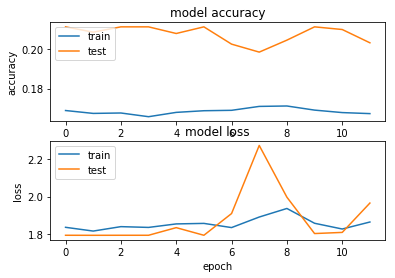

In [37]:

plt.figure(1)  

# summarize history for accuracy  

plt.subplot(211)  
plt.plot(history.history['acc'])  
plt.plot(history.history['val_acc'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  

# summarize history for loss  

plt.subplot(212)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
plt.show()

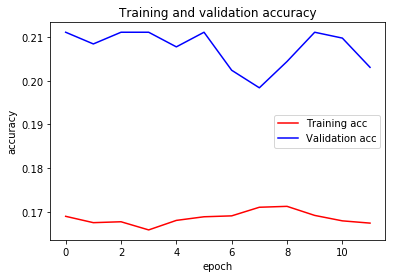

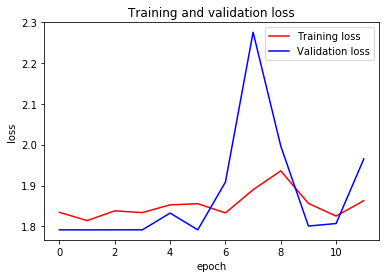

In [38]:
import matplotlib.pyplot as plt
%matplotlib inline 

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')  
plt.xlabel('epoch')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss')  
plt.xlabel('epoch')
plt.legend()
plt.show()

In [10]:
model.evaluate(test_data, test_labels)

120/120 [==============================] - 0s 578us/step


[1.7917594909667969, 0.16666666666666666]

In [121]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix

In [12]:
preds = np.round(model.predict(test_data),0)


In [13]:
preds = np.round(model.predict(test_data),0)
classification_metrics = metrics.classification_report(test_labels, preds)
print(classification_metrics)

In [14]:

print(classification_metrics)

              precision    recall  f1-score   support

           0       0.17      1.00      0.29        20
           1       0.17      1.00      0.29        20
           2       0.17      1.00      0.29        20
           3       0.17      1.00      0.29        20
           4       0.17      1.00      0.29        20
           5       0.17      1.00      0.29        20

   micro avg       0.17      1.00      0.29       120
   macro avg       0.17      1.00      0.29       120
weighted avg       0.17      1.00      0.29       120
 samples avg       0.17      1.00      0.29       120



## Training of Models

### Model 1: Basic model: one hidden layer

In [16]:

start = datetime.datetime.now()
model = Sequential()  
model.add(Flatten(input_shape=train_data.shape[1:]))  
model.add(Dense(256, activation='relu')) 
model.add(Dropout(0.5))  
model.add(Dense(num_classes, activation='sigmoid'))  

opt = SGD(lr=0.01)
model.compile(optimizer=opt,  
          loss='categorical_crossentropy', metrics=['accuracy'])  

history = model.fit(train_data, train_labels,  
      epochs=15,  
      batch_size=batch_size,  
      validation_data=(validation_data, validation_labels))  

model.save_weights(top_model_weights_path)  

(eval_loss, eval_accuracy) = model.evaluate(  
 validation_data, validation_labels, batch_size=batch_size, verbose=1)

print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100))  
print("[INFO] Loss: {}".format(eval_loss))  
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Train on 9625 samples, validate on 1492 samples
Epoch 1/15
9625/9625 [==============================] - 6s 612us/step - loss: 1.8268 - acc: 0.1666 - val_loss: 1.7918 - val_acc: 0.2111
Epoch 2/15
9625/9625 [==============================] - 5s 562us/step - loss: 1.7921 - acc: 0.1675 - val_loss: 1.7918 - val_acc: 0.2111
Epoch 3/15
9625/9625 [==============================] - 5s 565us/step - loss: 1.7923 - acc: 0.1670 - val_loss: 1.7918 - val_acc: 0.2111
Epoch 4/15
9625/9625 [==============================] - 6s 582us/step - loss: 1.7917 - acc: 0.1666 - val_loss: 1.7918 - val_acc: 0.2111
Epoch 5/15
9625/9625 [==============================] - 5s 565us/step - loss: 1.7917 - acc: 0.1682 - val_loss: 1.7918 - val_acc: 0.2111
Epoch 6/15
9625/9625 [==============================] - 6s 613us/step - loss: 1.7916 - acc: 0.1682 - val_loss: 1.7918 - val_acc: 0.2111
Epoch 7/15
9625/9625 [==============================] - 6s 629us/step - loss: 1.7916 - acc: 0.1676 - val_loss: 1.7918 - val_acc: 0.2111


In [19]:
start = datetime.datetime.now()
model = Sequential()  
model.add(Flatten(input_shape=train_data.shape[1:]))  
model.add(Dense(256, activation='relu')) 
model.add(Dropout(0.5))  
model.add(Dense(num_classes, activation='sigmoid'))  

opt = SGD(lr=0.01)
model.compile(optimizer='adam',  
          loss='categorical_crossentropy', metrics=['accuracy'])  

history = model.fit(train_data, train_labels,  
      epochs=15,  
      batch_size=batch_size,  
      validation_data=(validation_data, validation_labels))  

model.save_weights(top_model_weights_path)  

(eval_loss, eval_accuracy) = model.evaluate(  
 validation_data, validation_labels, batch_size=batch_size, verbose=1)

print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100))  
print("[INFO] Loss: {}".format(eval_loss))  
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Train on 9625 samples, validate on 1492 samples
Epoch 1/15
9625/9625 [==============================] - 9s 964us/step - loss: 1.8173 - acc: 0.1672 - val_loss: 1.7918 - val_acc: 0.2111
Epoch 2/15
9625/9625 [==============================] - 9s 935us/step - loss: 1.7917 - acc: 0.1673 - val_loss: 1.7918 - val_acc: 0.2111
Epoch 3/15
9625/9625 [==============================] - 10s 1ms/step - loss: 1.7917 - acc: 0.1674 - val_loss: 1.7918 - val_acc: 0.2111
Epoch 4/15
9625/9625 [==============================] - 9s 946us/step - loss: 1.7940 - acc: 0.1673 - val_loss: 1.7918 - val_acc: 0.2111
Epoch 5/15
9625/9625 [==============================] - 8s 828us/step - loss: 1.7926 - acc: 0.1676 - val_loss: 1.7918 - val_acc: 0.2111
Epoch 6/15
9625/9625 [==============================] - 8s 826us/step - loss: 1.8249 - acc: 0.1674 - val_loss: 1.7918 - val_acc: 0.2111
Epoch 7/15
9625/9625 [==============================] - 8s 826us/step - loss: 1.7917 - acc: 0.1672 - val_loss: 1.7918 - val_acc: 0.2111
E

In [17]:
### start = datetime.datetime.now()
model = Sequential()  
model.add(Flatten(input_shape=train_data.shape[1:]))  
model.add(Dense(200, activation='relu'))  
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu')) 
model.add(Dropout(0.6))
model.add(Dense(50, activation='relu'))  
model.add(Dense(num_classes, activation='sigmoid'))  

model.compile(optimizer='rmsprop',  
          loss='categorical_crossentropy', metrics=['accuracy'])  

history = model.fit(train_data, train_labels,  
      epochs=20,  
      batch_size=batch_size,  
      validation_data=(validation_data, validation_labels))  

model.save_weights(top_model_weights_path)  

(eval_loss, eval_accuracy) = model.evaluate(  
 validation_data, validation_labels, batch_size=batch_size, verbose=1)

print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100))  
print("[INFO] Loss: {}".format(eval_loss))  
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Train on 9625 samples, validate on 1492 samples
Epoch 1/20
9625/9625 [==============================] - 6s 643us/step - loss: 1.9005 - acc: 0.1680 - val_loss: 1.7918 - val_acc: 0.2111
Epoch 2/20
9625/9625 [==============================] - 5s 531us/step - loss: 1.8251 - acc: 0.1673 - val_loss: 1.7918 - val_acc: 0.2111
Epoch 3/20
9625/9625 [==============================] - 6s 600us/step - loss: 1.8232 - acc: 0.1682 - val_loss: 1.7918 - val_acc: 0.2111
Epoch 4/20
9625/9625 [==============================] - 6s 574us/step - loss: 1.8522 - acc: 0.1684 - val_loss: 1.7918 - val_acc: 0.2111
Epoch 5/20
9625/9625 [==============================] - 5s 551us/step - loss: 1.8477 - acc: 0.1671 - val_loss: 1.7918 - val_acc: 0.2111
Epoch 6/20
9625/9625 [==============================] - 6s 602us/step - loss: 1.8301 - acc: 0.1674 - val_loss: 1.7918 - val_acc: 0.2111
Epoch 7/20
9625/9625 [==============================] - 5s 553us/step - loss: 1.8423 - acc: 0.1670 - val_loss: 1.7918 - val_acc: 0.2111


In [20]:
start = datetime.datetime.now()
model = Sequential()  
model.add(Flatten(input_shape=train_data.shape[1:]))  
model.add(Dense(1000, activation='tanh'))  
model.add(Dropout(0.5)) 
model.add(Dense(750, activation='tanh'))
model.add(Dropout(0.33))
model.add(Dense(500, activation='tanh'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='sigmoid'))  

model.compile(optimizer='adam',  
          loss='categorical_crossentropy', metrics=['accuracy'])  

history = model.fit(train_data, train_labels,  
      epochs=50,  
      batch_size=batch_size,  
      validation_data=(validation_data, validation_labels))  

model.save_weights(top_model_weights_path, overwrite=False)  

(eval_loss, eval_accuracy) = model.evaluate(  
 validation_data, validation_labels, batch_size=batch_size, verbose=1)

print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100))  
print("[INFO] Loss: {}".format(eval_loss))  
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Train on 9625 samples, validate on 1492 samples
Epoch 1/50
9625/9625 [==============================] - 40s 4ms/step - loss: 1.7945 - acc: 0.1671 - val_loss: 1.7656 - val_acc: 0.2111
Epoch 2/50
9625/9625 [==============================] - 39s 4ms/step - loss: 1.7841 - acc: 0.1746 - val_loss: 1.7782 - val_acc: 0.2118
Epoch 3/50
9625/9625 [==============================] - 38s 4ms/step - loss: 1.7822 - acc: 0.1934 - val_loss: 1.8052 - val_acc: 0.2098
Epoch 4/50
9625/9625 [==============================] - 38s 4ms/step - loss: 1.7811 - acc: 0.1808 - val_loss: 1.7625 - val_acc: 0.2098
Epoch 5/50
9625/9625 [==============================] - 38s 4ms/step - loss: 1.7799 - acc: 0.1777 - val_loss: 1.7906 - val_acc: 0.1240
Epoch 6/50
9625/9625 [==============================] - 38s 4ms/step - loss: 1.7835 - acc: 0.1856 - val_loss: 1.7628 - val_acc: 0.0845
Epoch 7/50
9625/9625 [==============================] - 38s 4ms/step - loss: 1.7750 - acc: 0.1685 - val_loss: 1.8060 - val_acc: 0.0845
Epoch 8

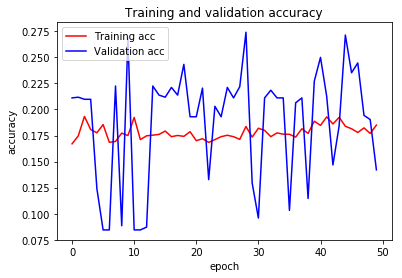

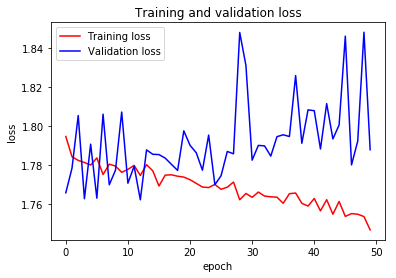

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline 

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')  
plt.xlabel('epoch')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss')  
plt.xlabel('epoch')
plt.legend()
plt.show()

In [22]:
model.evaluate(test_data, test_labels)

120/120 [==============================] - 0s 1ms/step


[1.8895282347997029, 0.16666666467984517]

In [24]:
# learning_rate = 0.1
# decay_rate = learning_rate / epochs
momentum = 0.8
learning_rate=0.01
sgd = SGD(lr=learning_rate, momentum=momentum, nesterov=False)
start = datetime.datetime.now()
model = Sequential()  
model.add(Flatten(input_shape=train_data.shape[1:]))  
model.add(Dense(1000, activation='tanh'))  
model.add(Dropout(0.5)) 
model.add(Dense(750, activation='tanh'))
model.add(Dropout(0.33))
model.add(Dense(500, activation='tanh'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='sigmoid'))  

model.compile(optimizer=sgd,  
          loss='categorical_crossentropy', metrics=['accuracy'])  

history = model.fit(train_data, train_labels,  
      epochs=75,  
      batch_size=1000,  
      validation_data=(validation_data, validation_labels))  

model.save_weights(top_model_weights_path)  

(eval_loss, eval_accuracy) = model.evaluate(  
 validation_data, validation_labels, batch_size=batch_size, verbose=1)

print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100))  
print("[INFO] Loss: {}".format(eval_loss))  
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Train on 9625 samples, validate on 1492 samples
Epoch 1/75
9625/9625 [==============================] - 13s 1ms/step - loss: 1.8339 - acc: 0.1816 - val_loss: 1.7830 - val_acc: 0.2084
Epoch 2/75
9625/9625 [==============================] - 13s 1ms/step - loss: 1.7804 - acc: 0.2044 - val_loss: 1.7805 - val_acc: 0.2058
Epoch 3/75
9625/9625 [==============================] - 14s 1ms/step - loss: 1.7760 - acc: 0.2127 - val_loss: 1.7781 - val_acc: 0.1930
Epoch 4/75
9625/9625 [==============================] - 12s 1ms/step - loss: 1.7653 - acc: 0.2264 - val_loss: 1.7728 - val_acc: 0.1917
Epoch 5/75
9625/9625 [==============================] - 12s 1ms/step - loss: 1.7620 - acc: 0.2345 - val_loss: 1.7734 - val_acc: 0.1964
Epoch 6/75
9625/9625 [==============================] - 12s 1ms/step - loss: 1.7503 - acc: 0.2449 - val_loss: 1.7729 - val_acc: 0.2105
Epoch 7/75
9625/9625 [==============================] - 12s 1ms/step - loss: 1.7430 - acc: 0.2612 - val_loss: 1.7728 - val_acc: 0.2165
Epoch 8

Epoch 61/75
9625/9625 [==============================] - 12s 1ms/step - loss: 1.0493 - acc: 0.5893 - val_loss: 2.1607 - val_acc: 0.3224
Epoch 62/75
9625/9625 [==============================] - 12s 1ms/step - loss: 1.0413 - acc: 0.5934 - val_loss: 2.2667 - val_acc: 0.3311
Epoch 63/75
9625/9625 [==============================] - 12s 1ms/step - loss: 1.0152 - acc: 0.6031 - val_loss: 2.1315 - val_acc: 0.3505
Epoch 64/75
9625/9625 [==============================] - 12s 1ms/step - loss: 0.9851 - acc: 0.6185 - val_loss: 2.2524 - val_acc: 0.3277
Epoch 65/75
9625/9625 [==============================] - 12s 1ms/step - loss: 0.9834 - acc: 0.6152 - val_loss: 2.2022 - val_acc: 0.3345
Epoch 66/75
9625/9625 [==============================] - 12s 1ms/step - loss: 1.0583 - acc: 0.5865 - val_loss: 2.7748 - val_acc: 0.2721
Epoch 67/75
9625/9625 [==============================] - 12s 1ms/step - loss: 1.0699 - acc: 0.5884 - val_loss: 2.3747 - val_acc: 0.3117
Epoch 68/75
9625/9625 [=========================

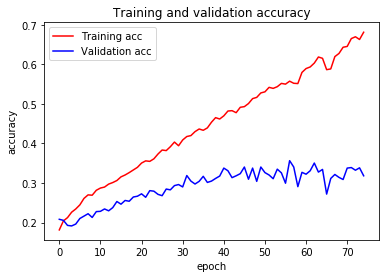

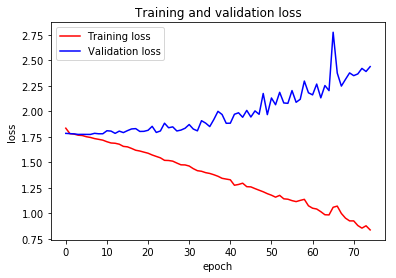

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline 

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')  
plt.xlabel('epoch')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss')  
plt.xlabel('epoch')
plt.legend()
plt.show()

In [26]:
model.evaluate(test_data, test_labels)

120/120 [==============================] - 0s 1ms/step


[5.000898170471191, 0.20000000049670538]

In [27]:
momentum = 0.8
learning_rate=0.01
sgd = SGD(lr=learning_rate, momentum=momentum, nesterov=False)
start = datetime.datetime.now()
model = Sequential()  
model.add(Flatten(input_shape=train_data.shape[1:]))  
model.add(Dense(1000, activation='tanh'))  
model.add(Dropout(0.5)) 
model.add(Dense(750, activation='tanh'))
model.add(Dropout(0.33))
model.add(Dense(500, activation='tanh'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))  

model.compile(optimizer=sgd,  
          loss='categorical_crossentropy', metrics=['accuracy'])  

history = model.fit(train_data, train_labels,  
      epochs=75,  
      batch_size=1000,  
      validation_data=(validation_data, validation_labels))  

model.save_weights(top_model_weights_path)  

(eval_loss, eval_accuracy) = model.evaluate(  
 validation_data, validation_labels, batch_size=batch_size, verbose=1)

print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100))  
print("[INFO] Loss: {}".format(eval_loss))  
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Train on 9625 samples, validate on 1492 samples
Epoch 1/75
9625/9625 [==============================] - 13s 1ms/step - loss: 2.2349 - acc: 0.1844 - val_loss: 1.8811 - val_acc: 0.2051
Epoch 2/75
9625/9625 [==============================] - 12s 1ms/step - loss: 2.0957 - acc: 0.2212 - val_loss: 1.8382 - val_acc: 0.2185
Epoch 3/75
9625/9625 [==============================] - 12s 1ms/step - loss: 2.0297 - acc: 0.2228 - val_loss: 1.8455 - val_acc: 0.2245
Epoch 4/75
9625/9625 [==============================] - 12s 1ms/step - loss: 1.9585 - acc: 0.2431 - val_loss: 1.8263 - val_acc: 0.2332
Epoch 5/75
9625/9625 [==============================] - 12s 1ms/step - loss: 1.9167 - acc: 0.2525 - val_loss: 1.8521 - val_acc: 0.2151
Epoch 6/75
9625/9625 [==============================] - 12s 1ms/step - loss: 1.8832 - acc: 0.2634 - val_loss: 1.9328 - val_acc: 0.2332
Epoch 7/75
9625/9625 [==============================] - 12s 1ms/step - loss: 1.8408 - acc: 0.2771 - val_loss: 1.8661 - val_acc: 0.2420
Epoch 8

Epoch 61/75
9625/9625 [==============================] - 14s 1ms/step - loss: 0.9199 - acc: 0.6501 - val_loss: 2.1991 - val_acc: 0.3492
Epoch 62/75
9625/9625 [==============================] - 14s 1ms/step - loss: 0.9740 - acc: 0.6277 - val_loss: 2.1963 - val_acc: 0.3479
Epoch 63/75
9625/9625 [==============================] - 12s 1ms/step - loss: 0.9294 - acc: 0.6442 - val_loss: 2.3801 - val_acc: 0.3036
Epoch 64/75
9625/9625 [==============================] - 13s 1ms/step - loss: 0.9314 - acc: 0.6416 - val_loss: 2.2760 - val_acc: 0.3345
Epoch 65/75
9625/9625 [==============================] - 16s 2ms/step - loss: 0.8668 - acc: 0.6647 - val_loss: 2.2513 - val_acc: 0.3378
Epoch 66/75
9625/9625 [==============================] - 14s 1ms/step - loss: 0.7947 - acc: 0.6976 - val_loss: 2.2509 - val_acc: 0.3391
Epoch 67/75
9625/9625 [==============================] - 15s 2ms/step - loss: 0.7878 - acc: 0.7054 - val_loss: 2.4065 - val_acc: 0.3318
Epoch 68/75
9625/9625 [=========================

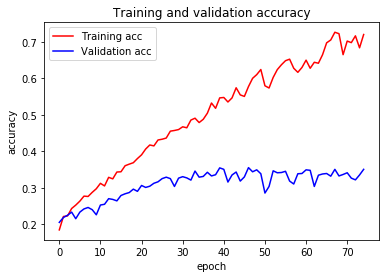

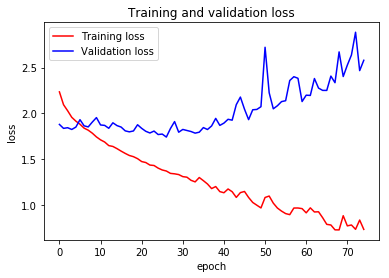

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline 

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')  
plt.xlabel('epoch')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss')  
plt.xlabel('epoch')
plt.legend()
plt.show()

In [31]:
model.evaluate(test_data, test_labels)

120/120 [==============================] - 0s 1ms/step


[6.5421548843383786, 0.225]

## Best Model so far at  predicting

In [32]:
momentum = 0.8
learning_rate=0.01
sgd = SGD(lr=learning_rate, momentum=momentum, nesterov=False)
start = datetime.datetime.now()
model = Sequential()  
model.add(Flatten(input_shape=train_data.shape[1:]))  
model.add(Dense(1000, activation='tanh'))  
model.add(Dropout(0.5)) 
model.add(Dense(750, activation='tanh'))
model.add(Dropout(0.33))
model.add(Dense(500, activation='tanh'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))  

model.compile(optimizer=sgd,  
          loss='categorical_crossentropy', metrics=['accuracy'])  

history = model.fit(train_data, train_labels,  
      epochs=35,  
      batch_size=500,  
      validation_data=(validation_data, validation_labels))  

model.save_weights(top_model_weights_path)  

(eval_loss, eval_accuracy) = model.evaluate(  
 validation_data, validation_labels, batch_size=batch_size, verbose=1)

print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100))  
print("[INFO] Loss: {}".format(eval_loss))  
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Train on 9625 samples, validate on 1492 samples
Epoch 1/35
9625/9625 [==============================] - 17s 2ms/step - loss: 2.1970 - acc: 0.1906 - val_loss: 1.7939 - val_acc: 0.1991
Epoch 2/35
9625/9625 [==============================] - 14s 1ms/step - loss: 2.0563 - acc: 0.2090 - val_loss: 1.8521 - val_acc: 0.2098
Epoch 3/35
9625/9625 [==============================] - 14s 1ms/step - loss: 1.9915 - acc: 0.2195 - val_loss: 1.8137 - val_acc: 0.2178
Epoch 4/35
9625/9625 [==============================] - 14s 1ms/step - loss: 1.9230 - acc: 0.2274 - val_loss: 1.8249 - val_acc: 0.2145
Epoch 5/35
9625/9625 [==============================] - 17s 2ms/step - loss: 1.8739 - acc: 0.2435 - val_loss: 1.8560 - val_acc: 0.2286
Epoch 6/35
9625/9625 [==============================] - 15s 2ms/step - loss: 1.8223 - acc: 0.2550 - val_loss: 1.8185 - val_acc: 0.2259
Epoch 7/35
9625/9625 [==============================] - 15s 2ms/step - loss: 1.7846 - acc: 0.2601 - val_loss: 1.8551 - val_acc: 0.2044
Epoch 8

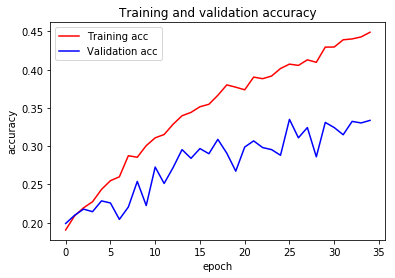

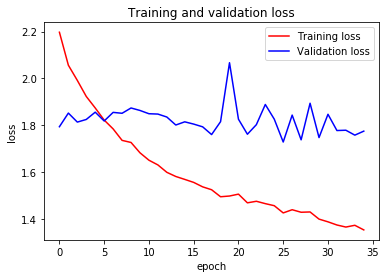

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline 

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')  
plt.xlabel('epoch')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss')  
plt.xlabel('epoch')
plt.legend()
plt.show()

In [34]:
model.evaluate(test_data, test_labels)

120/120 [==============================] - 0s 1ms/step


[3.8865585009257, 0.24166666691501934]

Train on 9625 samples, validate on 1492 samples
Epoch 1/35
9625/9625 [==============================] - 12s 1ms/step - loss: 2.1567 - acc: 0.1983 - val_loss: 1.8661 - val_acc: 0.2145
Epoch 2/35
9625/9625 [==============================] - 11s 1ms/step - loss: 2.0014 - acc: 0.2334 - val_loss: 1.8071 - val_acc: 0.2178
Epoch 3/35
9625/9625 [==============================] - 11s 1ms/step - loss: 1.9132 - acc: 0.2494 - val_loss: 1.9256 - val_acc: 0.2272
Epoch 4/35
9625/9625 [==============================] - 11s 1ms/step - loss: 1.8712 - acc: 0.2515 - val_loss: 1.8782 - val_acc: 0.2279
Epoch 5/35
9625/9625 [==============================] - 11s 1ms/step - loss: 1.8141 - acc: 0.2710 - val_loss: 1.8691 - val_acc: 0.2473
Epoch 6/35
9625/9625 [==============================] - 11s 1ms/step - loss: 1.7509 - acc: 0.2898 - val_loss: 1.8743 - val_acc: 0.2426
Epoch 7/35
9625/9625 [==============================] - 11s 1ms/step - loss: 1.7149 - acc: 0.3030 - val_loss: 1.9125 - val_acc: 0.2473
Epoch 8

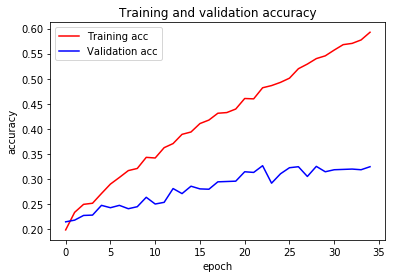

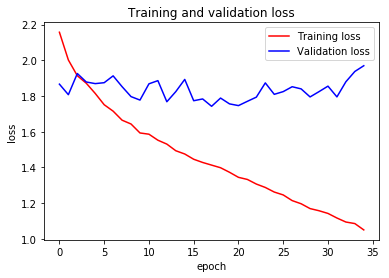

In [49]:
momentum = 0.65
learning_rate=0.01
decay= .001 #at 0.001 acc of 32 predict at 22
sgd = SGD(lr=learning_rate, decay= decay, momentum=momentum, nesterov=False)
start = datetime.datetime.now()
model = Sequential()  
model.add(Flatten(input_shape=train_data.shape[1:]))  
model.add(Dense(750, activation='tanh'))  
model.add(Dropout(0.5)) 
model.add(Dense(350, activation='tanh'))
model.add(Dropout(0.33))
model.add(Dense(num_classes, activation='softmax'))  

model.compile(optimizer=sgd,  
          loss='categorical_crossentropy', metrics=['accuracy'])  

history = model.fit(train_data, train_labels,  
      epochs=35,  
      batch_size=250,  
      validation_data=(validation_data, validation_labels))  

model.save_weights(top_model_weights_path)  

(eval_loss, eval_accuracy) = model.evaluate(  
 validation_data, validation_labels, batch_size=batch_size, verbose=1)

print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100))  
print("[INFO] Loss: {}".format(eval_loss))  
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

#Graphing
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')  
plt.xlabel('epoch')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss')  
plt.xlabel('epoch')
plt.legend()
plt.show()

In [50]:
model.evaluate(test_data, test_labels)

120/120 [==============================] - 0s 1ms/step


[4.502890396118164, 0.19166666666666668]

Train on 9625 samples, validate on 1492 samples
Epoch 1/25
9625/9625 [==============================] - 24s 3ms/step - loss: 2.1222 - acc: 0.1814 - val_loss: 1.8085 - val_acc: 0.1984
Epoch 2/25
9625/9625 [==============================] - 25s 3ms/step - loss: 1.9130 - acc: 0.2003 - val_loss: 1.7991 - val_acc: 0.2178
Epoch 3/25
9625/9625 [==============================] - 26s 3ms/step - loss: 1.8293 - acc: 0.2127 - val_loss: 1.9679 - val_acc: 0.1790
Epoch 4/25
9625/9625 [==============================] - 25s 3ms/step - loss: 1.7732 - acc: 0.2459 - val_loss: 1.8891 - val_acc: 0.2634
Epoch 5/25
9625/9625 [==============================] - 27s 3ms/step - loss: 1.7386 - acc: 0.2587 - val_loss: 1.8860 - val_acc: 0.2198
Epoch 6/25
9625/9625 [==============================] - 24s 3ms/step - loss: 1.7331 - acc: 0.2614 - val_loss: 1.9139 - val_acc: 0.2621
Epoch 7/25
9625/9625 [==============================] - 24s 3ms/step - loss: 1.7194 - acc: 0.2682 - val_loss: 1.8813 - val_acc: 0.2138
Epoch 8

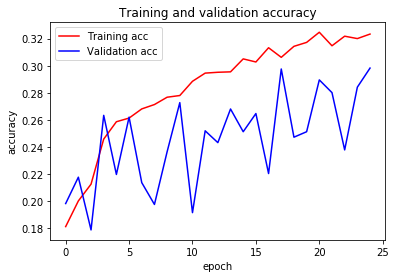

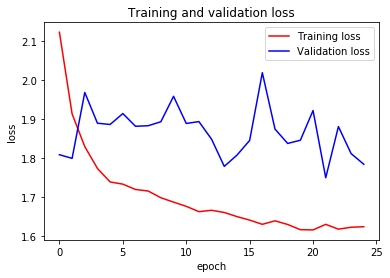

In [35]:
momentum = 0.8
learning_rate=0.01
sgd = SGD(lr=learning_rate, momentum=momentum, nesterov=False)
start = datetime.datetime.now()
model = Sequential()  
model.add(Flatten(input_shape=train_data.shape[1:]))  
model.add(Dense(1000, activation='tanh'))  
model.add(Dropout(0.5)) 
model.add(Dense(750, activation='tanh'))
model.add(Dropout(0.33))
model.add(Dense(500, activation='tanh'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))  

model.compile(optimizer=sgd,  
          loss='categorical_crossentropy', metrics=['accuracy'])  

history = model.fit(train_data, train_labels,  
      epochs=25,  
      batch_size=100,  
      validation_data=(validation_data, validation_labels))  

model.save_weights(top_model_weights_path)  

(eval_loss, eval_accuracy) = model.evaluate(  
 validation_data, validation_labels, batch_size=batch_size, verbose=1)

print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100))  
print("[INFO] Loss: {}".format(eval_loss))  
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

import matplotlib.pyplot as plt
%matplotlib inline 

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')  
plt.xlabel('epoch')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss')  
plt.xlabel('epoch')
plt.legend()
plt.show()

In [36]:
model.evaluate(test_data, test_labels)

120/120 [==============================] - 0s 1ms/step


[2.930336840947469, 0.19166666666666668]

Train on 9625 samples, validate on 1492 samples
Epoch 1/30
9625/9625 [==============================] - 44s 5ms/step - loss: 2.3249 - acc: 0.1743 - val_loss: 1.9212 - val_acc: 0.2172
Epoch 2/30
9625/9625 [==============================] - 40s 4ms/step - loss: 2.1402 - acc: 0.1928 - val_loss: 1.8301 - val_acc: 0.2239
Epoch 3/30
9625/9625 [==============================] - 42s 4ms/step - loss: 2.0184 - acc: 0.2049 - val_loss: 1.7717 - val_acc: 0.1749
Epoch 4/30
9625/9625 [==============================] - 38s 4ms/step - loss: 1.9269 - acc: 0.2145 - val_loss: 1.8239 - val_acc: 0.1153
Epoch 5/30
9625/9625 [==============================] - 38s 4ms/step - loss: 1.8725 - acc: 0.2210 - val_loss: 1.8216 - val_acc: 0.1749
Epoch 6/30
9625/9625 [==============================] - 38s 4ms/step - loss: 1.8043 - acc: 0.2326 - val_loss: 1.8272 - val_acc: 0.1542
Epoch 7/30
9625/9625 [==============================] - 40s 4ms/step - loss: 1.7845 - acc: 0.2374 - val_loss: 1.8377 - val_acc: 0.2292
Epoch 8

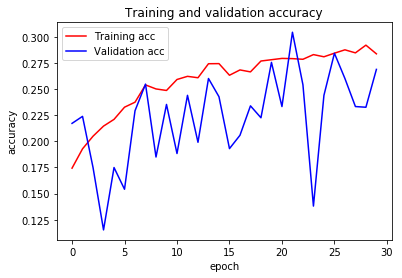

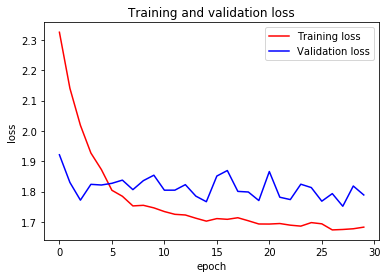

In [37]:
momentum = 0.8
learning_rate=0.01
sgd = SGD(lr=learning_rate, momentum=momentum, nesterov=False)
start = datetime.datetime.now()
model = Sequential()  
model.add(Flatten(input_shape=train_data.shape[1:]))  
model.add(Dense(1000, activation='tanh'))  
model.add(Dropout(0.5)) 
model.add(Dense(750, activation='tanh'))
model.add(Dropout(0.33))
model.add(Dense(500, activation='tanh'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))  

model.compile(optimizer='adam',  
          loss='categorical_crossentropy', metrics=['accuracy'])  

history = model.fit(train_data, train_labels,  
      epochs=30,  
      batch_size=100,  
      validation_data=(validation_data, validation_labels))  

model.save_weights(top_model_weights_path)  

(eval_loss, eval_accuracy) = model.evaluate(  
 validation_data, validation_labels, batch_size=batch_size, verbose=1)

print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100))  
print("[INFO] Loss: {}".format(eval_loss))  
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

import matplotlib.pyplot as plt
%matplotlib inline 

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')  
plt.xlabel('epoch')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss')  
plt.xlabel('epoch')
plt.legend()
plt.show()

In [38]:
model.evaluate(test_data, test_labels)

120/120 [==============================] - 0s 1ms/step


[2.174639368057251, 0.16666666666666666]

## Using Talos to find best model fit

In [109]:
from talos import *
import talos as ta
import tqdm

In [107]:
def talosp():
    p= {'hidden_layers': [750, 500, 250, 100],
        'batch_size': [100, 500, 1000],
        'epochs':[15, 25, 35, 50]}

    
def cell_model(train_data, train_labels, validation_data, validation_labels, params):
    model = Sequential()  
    model.add(Flatten(input_shape=train_data.shape[1:]))  
    model.add(Dense(750, activation='tanh'))  
    model.add(Dropout(.5)) 
    model.add(Dense(350, activation='tanh'))
    model.add(Dropout(0.33))
    model.add(Dense(num_classes, activation='softmax'))  
    model.compile(optimizer=sgd, 
                  loss='categorical_crossentropy', metrics=['accuracy']) 
    history = model.fit(train_data, train_labels,  
                        epochs=params['epochs'],  
                        batch_size=params['batch_size'],  
                        validation_data=(validation_data, validation_labels))
    return history, model


In [115]:
import tensorflow as tf
tf.reset_default_graph()

In [120]:
# start = datetime.datetime.now()
tf.reset_default_graph()
scan= Scan(train_data, train_labels, model= cell_model, params=p, grid_downsample= .1)
return scan
# end= datetime.datetime.now()
# elapsed= end-start
# print ('Time: ', elapsed)


























  0%|          | 0/7 [00:00<?, ?it/s]

ValueError: Tensor("training/SGD/Variable:0", shape=(25088, 750), dtype=float32_ref) must be from the same graph as Tensor("SGD_12/momentum/read:0", shape=(), dtype=float32).

# Rerunning Best Model and modify it afterward

#### model 1

In [122]:
momentum = 0.8
learning_rate=0.01
sgd = SGD(lr=learning_rate, momentum=momentum, nesterov=False)
start = datetime.datetime.now()
model = Sequential()  
model.add(Flatten(input_shape=train_data.shape[1:]))  
model.add(Dense(1000, activation='tanh'))  
model.add(Dropout(0.5)) 
model.add(Dense(750, activation='tanh'))
model.add(Dropout(0.33))
model.add(Dense(500, activation='tanh'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))  

model.compile(optimizer=sgd,  
          loss='categorical_crossentropy', metrics=['accuracy'])  

history = model.fit(train_data, train_labels,  
      epochs=35,  
      batch_size=500,  
      validation_data=(validation_data, validation_labels))  

model.save_weights(top_model_weights_path)  

(eval_loss, eval_accuracy) = model.evaluate(  
 validation_data, validation_labels, batch_size=batch_size, verbose=1)

print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100))  
print("[INFO] Loss: {}".format(eval_loss))  
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Train on 9625 samples, validate on 1492 samples
Epoch 1/35
9625/9625 [==============================] - 15s 2ms/step - loss: 2.2048 - acc: 0.1929 - val_loss: 1.8343 - val_acc: 0.2105
Epoch 2/35
9625/9625 [==============================] - 13s 1ms/step - loss: 2.0733 - acc: 0.2128 - val_loss: 1.7923 - val_acc: 0.2131
Epoch 3/35
9625/9625 [==============================] - 14s 1ms/step - loss: 1.9828 - acc: 0.2223 - val_loss: 1.7962 - val_acc: 0.2125
Epoch 4/35
9625/9625 [==============================] - 14s 1ms/step - loss: 1.9083 - acc: 0.2408 - val_loss: 1.8587 - val_acc: 0.2011
Epoch 5/35
9625/9625 [==============================] - 14s 1ms/step - loss: 1.8525 - acc: 0.2515 - val_loss: 1.8468 - val_acc: 0.2272
Epoch 6/35
9625/9625 [==============================] - 14s 1ms/step - loss: 1.8043 - acc: 0.2610 - val_loss: 1.8945 - val_acc: 0.2185
Epoch 7/35
9625/9625 [==============================] - 13s 1ms/step - loss: 1.7772 - acc: 0.2696 - val_loss: 1.8735 - val_acc: 0.2151
Epoch 8

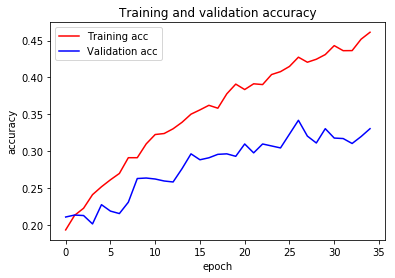

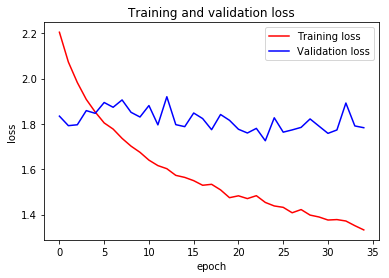

In [123]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')  
plt.xlabel('epoch')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss')  
plt.xlabel('epoch')
plt.legend()
plt.show()

In [124]:
model.evaluate(test_data, test_labels)

120/120 [==============================] - 0s 1ms/step


[3.922544765472412, 0.2500000004967054]

In [125]:
preds = np.round(model.predict(test_data),0)
classification_metrics = metrics.classification_report(test_labels, preds)
print(classification_metrics)

              precision    recall  f1-score   support

           0       0.38      0.15      0.21        20
           1       0.00      0.00      0.00        20
           2       0.00      0.00      0.00        20
           3       0.19      0.70      0.30        20
           4       1.00      0.15      0.26        20
           5       0.50      0.05      0.09        20

   micro avg       0.24      0.17      0.20       120
   macro avg       0.34      0.18      0.15       120
weighted avg       0.34      0.17      0.15       120
 samples avg       0.17      0.17      0.17       120



### Result from model 1:

accuracy at 33 with loss of 1.78 and evaluate at 25% with loss of 3.9

classification states model bad at precision on endosome and er

plateu at epoch 25


#### model 2, less epoch (25) same batch size 

Train on 9625 samples, validate on 1492 samples
Epoch 1/25
9625/9625 [==============================] - 14s 1ms/step - loss: 2.2135 - acc: 0.1968 - val_loss: 1.8240 - val_acc: 0.2105
Epoch 2/25
9625/9625 [==============================] - 14s 1ms/step - loss: 2.0652 - acc: 0.2135 - val_loss: 1.9366 - val_acc: 0.1836
Epoch 3/25
9625/9625 [==============================] - 14s 1ms/step - loss: 1.9807 - acc: 0.2278 - val_loss: 1.8459 - val_acc: 0.2198
Epoch 4/25
9625/9625 [==============================] - 14s 1ms/step - loss: 1.9120 - acc: 0.2407 - val_loss: 1.8205 - val_acc: 0.2178
Epoch 5/25
9625/9625 [==============================] - 14s 1ms/step - loss: 1.8579 - acc: 0.2556 - val_loss: 1.7964 - val_acc: 0.2353
Epoch 6/25
9625/9625 [==============================] - 14s 1ms/step - loss: 1.8251 - acc: 0.2571 - val_loss: 1.8812 - val_acc: 0.2446
Epoch 7/25
9625/9625 [==============================] - 14s 1ms/step - loss: 1.7791 - acc: 0.2732 - val_loss: 1.8988 - val_acc: 0.2507
Epoch 8

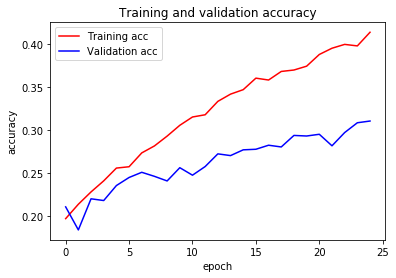

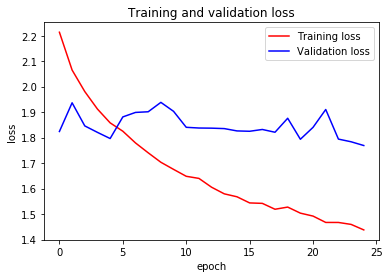

In [129]:
momentum = 0.8
learning_rate=0.01
sgd = SGD(lr=learning_rate, momentum=momentum, nesterov=False)
start = datetime.datetime.now()
model = Sequential()  
model.add(Flatten(input_shape=train_data.shape[1:]))  
model.add(Dense(1000, activation='tanh'))  
model.add(Dropout(0.5)) 
model.add(Dense(750, activation='tanh'))
model.add(Dropout(0.33))
model.add(Dense(500, activation='tanh'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))  

model.compile(optimizer=sgd,  
          loss='categorical_crossentropy', metrics=['accuracy'])  

history = model.fit(train_data, train_labels,  
      epochs=25,  
      batch_size=500,  
      validation_data=(validation_data, validation_labels))  

model.save_weights(top_model_weights_path)  

(eval_loss, eval_accuracy) = model.evaluate(  
 validation_data, validation_labels, batch_size=batch_size, verbose=1)

print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100))  
print("[INFO] Loss: {}".format(eval_loss))  
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')  
plt.xlabel('epoch')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss')  
plt.xlabel('epoch')
plt.legend()
plt.show()

In [130]:
model.evaluate(test_data, test_labels)

120/120 [==============================] - 0s 2ms/step


[3.773895772298177, 0.21666666716337205]

In [131]:
preds = np.round(model.predict(test_data),0)
classification_metrics = metrics.classification_report(test_labels, preds)
print(classification_metrics)

              precision    recall  f1-score   support

           0       0.40      0.10      0.16        20
           1       0.00      0.00      0.00        20
           2       0.00      0.00      0.00        20
           3       0.18      0.70      0.29        20
           4       0.00      0.00      0.00        20
           5       0.00      0.00      0.00        20

   micro avg       0.19      0.13      0.16       120
   macro avg       0.10      0.13      0.07       120
weighted avg       0.10      0.13      0.07       120
 samples avg       0.13      0.13      0.13       120



#### Result from model 2


accuracy of 31 with loss of 1.79 

model eval at 21 with loss at 3.77

precision: same issues but now missing mitochondria and nucleus

#### model 3. same as model 1 but with decay rate

Train on 9625 samples, validate on 1492 samples
Epoch 1/35
9625/9625 [==============================] - 14s 2ms/step - loss: 2.1942 - acc: 0.1956 - val_loss: 1.7993 - val_acc: 0.2259
Epoch 2/35
9625/9625 [==============================] - 14s 1ms/step - loss: 2.0670 - acc: 0.2113 - val_loss: 1.9998 - val_acc: 0.1790
Epoch 3/35
9625/9625 [==============================] - 14s 1ms/step - loss: 1.9791 - acc: 0.2315 - val_loss: 1.8205 - val_acc: 0.2111
Epoch 4/35
9625/9625 [==============================] - 14s 1ms/step - loss: 1.9161 - acc: 0.2382 - val_loss: 1.7953 - val_acc: 0.2138
Epoch 5/35
9625/9625 [==============================] - 14s 1ms/step - loss: 1.8575 - acc: 0.2481 - val_loss: 1.8612 - val_acc: 0.2493
Epoch 6/35
9625/9625 [==============================] - 14s 1ms/step - loss: 1.8068 - acc: 0.2638 - val_loss: 1.8398 - val_acc: 0.2534
Epoch 7/35
9625/9625 [==============================] - 14s 1ms/step - loss: 1.7662 - acc: 0.2778 - val_loss: 1.8281 - val_acc: 0.2413
Epoch 8

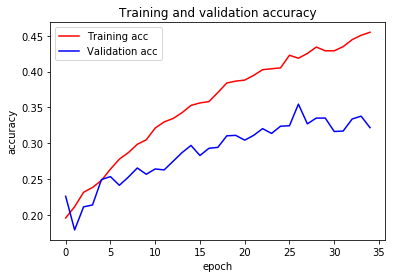

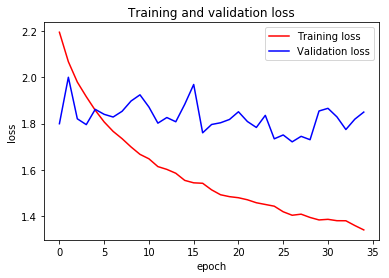

In [132]:
momentum = 0.8
learning_rate=0.01
decay_rate= .001
sgd = SGD(lr=learning_rate, momentum=momentum, nesterov=False)
start = datetime.datetime.now()
model = Sequential()  
model.add(Flatten(input_shape=train_data.shape[1:]))  
model.add(Dense(1000, activation='tanh'))  
model.add(Dropout(0.5)) 
model.add(Dense(750, activation='tanh'))
model.add(Dropout(0.33))
model.add(Dense(500, activation='tanh'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))  

model.compile(optimizer=sgd,  
          loss='categorical_crossentropy', metrics=['accuracy'])  

history = model.fit(train_data, train_labels,  
      epochs=35,  
      batch_size=500,  
      validation_data=(validation_data, validation_labels))  

model.save_weights(top_model_weights_path)  

(eval_loss, eval_accuracy) = model.evaluate(  
 validation_data, validation_labels, batch_size=batch_size, verbose=1)

print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100))  
print("[INFO] Loss: {}".format(eval_loss))  
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')  
plt.xlabel('epoch')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss')  
plt.xlabel('epoch')
plt.legend()
plt.show()

In [133]:
model.evaluate(test_data, test_labels)

120/120 [==============================] - 0s 1ms/step


[4.3304209073384605, 0.20833333358168601]

In [134]:
preds = np.round(model.predict(test_data),0)
classification_metrics = metrics.classification_report(test_labels, preds)
print(classification_metrics)

              precision    recall  f1-score   support

           0       0.67      0.10      0.17        20
           1       0.00      0.00      0.00        20
           2       0.00      0.00      0.00        20
           3       0.20      0.80      0.32        20
           4       0.30      0.15      0.20        20
           5       0.00      0.00      0.00        20

   micro avg       0.22      0.17      0.19       120
   macro avg       0.19      0.18      0.12       120
weighted avg       0.19      0.17      0.12       120
 samples avg       0.17      0.17      0.17       120



#### model 4. same as model 3 but no dropout

Train on 9625 samples, validate on 1492 samples
Epoch 1/35
9625/9625 [==============================] - 13s 1ms/step - loss: 2.2377 - acc: 0.2177 - val_loss: 1.8142 - val_acc: 0.2098
Epoch 2/35
9625/9625 [==============================] - 13s 1ms/step - loss: 1.6690 - acc: 0.2930 - val_loss: 1.8071 - val_acc: 0.2198
Epoch 3/35
9625/9625 [==============================] - 13s 1ms/step - loss: 1.5538 - acc: 0.3647 - val_loss: 1.8438 - val_acc: 0.2265
Epoch 4/35
9625/9625 [==============================] - 13s 1ms/step - loss: 1.4632 - acc: 0.4222 - val_loss: 1.9395 - val_acc: 0.1655
Epoch 5/35
9625/9625 [==============================] - 13s 1ms/step - loss: 1.3743 - acc: 0.4552 - val_loss: 1.7271 - val_acc: 0.2755
Epoch 6/35
9625/9625 [==============================] - 13s 1ms/step - loss: 1.4681 - acc: 0.4272 - val_loss: 2.3751 - val_acc: 0.1676
Epoch 7/35
9625/9625 [==============================] - 13s 1ms/step - loss: 1.4059 - acc: 0.4409 - val_loss: 1.7957 - val_acc: 0.2466
Epoch 8

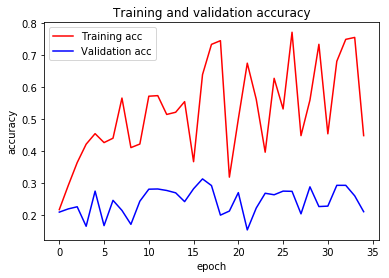

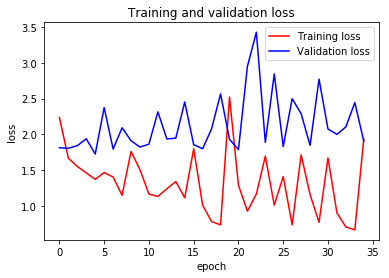

In [135]:
momentum = 0.8
learning_rate=0.01
decay_rate= .001
sgd = SGD(lr=learning_rate, momentum=momentum, nesterov=False)
start = datetime.datetime.now()
model = Sequential()  
model.add(Flatten(input_shape=train_data.shape[1:]))  
model.add(Dense(1000, activation='tanh'))  
# model.add(Dropout(0.5)) 
model.add(Dense(750, activation='tanh'))
# model.add(Dropout(0.33))
model.add(Dense(500, activation='tanh'))
# model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))  

model.compile(optimizer=sgd,  
          loss='categorical_crossentropy', metrics=['accuracy'])  

history = model.fit(train_data, train_labels,  
      epochs=35,  
      batch_size=500,  
      validation_data=(validation_data, validation_labels))  

model.save_weights(top_model_weights_path)  

(eval_loss, eval_accuracy) = model.evaluate(  
 validation_data, validation_labels, batch_size=batch_size, verbose=1)

print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100))  
print("[INFO] Loss: {}".format(eval_loss))  
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')  
plt.xlabel('epoch')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss')  
plt.xlabel('epoch')
plt.legend()
plt.show()

In [136]:
model.evaluate(test_data, test_labels)

120/120 [==============================] - 0s 984us/step


[2.5188842455546063, 0.18333333358168602]

In [137]:
preds = np.round(model.predict(test_data),0)
classification_metrics = metrics.classification_report(test_labels, preds)
print(classification_metrics)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        20
           1       0.00      0.00      0.00        20
           2       0.00      0.00      0.00        20
           3       0.22      0.55      0.32        20
           4       0.21      0.15      0.18        20
           5       0.00      0.00      0.00        20

   micro avg       0.21      0.12      0.15       120
   macro avg       0.07      0.12      0.08       120
weighted avg       0.07      0.12      0.08       120
 samples avg       0.12      0.12      0.12       120



#### model 5, same as model 1 but with 2 hidden layers

Train on 9625 samples, validate on 1492 samples
Epoch 1/35
9625/9625 [==============================] - 10s 1ms/step - loss: 2.3059 - acc: 0.1990 - val_loss: 1.8591 - val_acc: 0.2051
Epoch 2/35
9625/9625 [==============================] - 9s 980us/step - loss: 2.0472 - acc: 0.2233 - val_loss: 1.8592 - val_acc: 0.2051
Epoch 3/35
9625/9625 [==============================] - 10s 1ms/step - loss: 1.9488 - acc: 0.2458 - val_loss: 1.8552 - val_acc: 0.2265
Epoch 4/35
9625/9625 [==============================] - 10s 995us/step - loss: 1.8922 - acc: 0.2613 - val_loss: 1.8503 - val_acc: 0.2145
Epoch 5/35
9625/9625 [==============================] - 10s 1ms/step - loss: 1.8063 - acc: 0.2777 - val_loss: 1.7812 - val_acc: 0.2366
Epoch 6/35
9625/9625 [==============================] - 10s 1ms/step - loss: 1.7573 - acc: 0.2862 - val_loss: 1.8327 - val_acc: 0.2272
Epoch 7/35
9625/9625 [==============================] - 10s 1ms/step - loss: 1.6974 - acc: 0.3047 - val_loss: 1.8056 - val_acc: 0.2393
Epoc

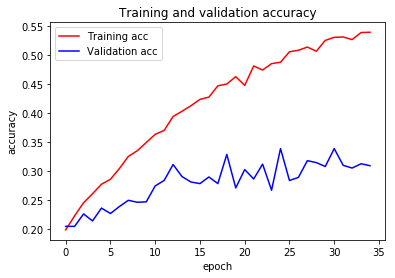

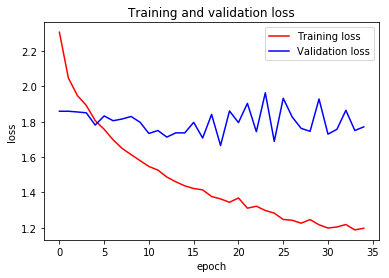

In [138]:
momentum = 0.8
learning_rate=0.01
# decay_rate= .001
sgd = SGD(lr=learning_rate, momentum=momentum, nesterov=False)
start = datetime.datetime.now()
model = Sequential()  
model.add(Flatten(input_shape=train_data.shape[1:]))  
# model.add(Dense(1000, activation='tanh'))  
# model.add(Dropout(0.5)) 
model.add(Dense(750, activation='tanh'))
model.add(Dropout(0.33))
model.add(Dense(350, activation='tanh'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))  

model.compile(optimizer=sgd,  
          loss='categorical_crossentropy', metrics=['accuracy'])  

history = model.fit(train_data, train_labels,  
      epochs=35,  
      batch_size=500,  
      validation_data=(validation_data, validation_labels))  

model.save_weights(top_model_weights_path)  

(eval_loss, eval_accuracy) = model.evaluate(  
 validation_data, validation_labels, batch_size=batch_size, verbose=1)

print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100))  
print("[INFO] Loss: {}".format(eval_loss))  
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')  
plt.xlabel('epoch')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss')  
plt.xlabel('epoch')
plt.legend()
plt.show()

In [139]:
model.evaluate(test_data, test_labels)

120/120 [==============================] - 0s 1ms/step


[3.9169532457987466, 0.20833333358168601]

In [140]:
preds = np.round(model.predict(test_data),0)
classification_metrics = metrics.classification_report(test_labels, preds)
print(classification_metrics)

              precision    recall  f1-score   support

           0       0.33      0.10      0.15        20
           1       0.33      0.05      0.09        20
           2       0.00      0.00      0.00        20
           3       0.18      0.70      0.29        20
           4       0.60      0.15      0.24        20
           5       0.00      0.00      0.00        20

   micro avg       0.22      0.17      0.19       120
   macro avg       0.24      0.17      0.13       120
weighted avg       0.24      0.17      0.13       120
 samples avg       0.17      0.17      0.17       120



In [142]:
class_dictionary = generator_top.class_indices 
class_dictionary

{'cytoplasm': 0,
 'endosome': 1,
 'er': 2,
 'golgi': 3,
 'mitochondrion': 4,
 'nucleus': 5}

#### model 6: model 1 but with leakyrelu instead of tanh

Train on 9625 samples, validate on 1492 samples
Epoch 1/35
9625/9625 [==============================] - 17s 2ms/step - loss: 11.7301 - acc: 0.1710 - val_loss: 11.8879 - val_acc: 0.2111
Epoch 2/35
9625/9625 [==============================] - 16s 2ms/step - loss: 11.8391 - acc: 0.2047 - val_loss: 9.4149 - val_acc: 0.1743
Epoch 3/35
9625/9625 [==============================] - 15s 2ms/step - loss: 9.1201 - acc: 0.2412 - val_loss: 4.5205 - val_acc: 0.2198
Epoch 4/35
9625/9625 [==============================] - 14s 1ms/step - loss: 3.9500 - acc: 0.2369 - val_loss: 1.9095 - val_acc: 0.1964
Epoch 5/35
9625/9625 [==============================] - 15s 2ms/step - loss: 1.9642 - acc: 0.2725 - val_loss: 1.8840 - val_acc: 0.2332
Epoch 6/35
9625/9625 [==============================] - 15s 2ms/step - loss: 1.7427 - acc: 0.3006 - val_loss: 1.7750 - val_acc: 0.2507
Epoch 7/35
9625/9625 [==============================] - 15s 2ms/step - loss: 1.6592 - acc: 0.3205 - val_loss: 1.7421 - val_acc: 0.2453
Epoc

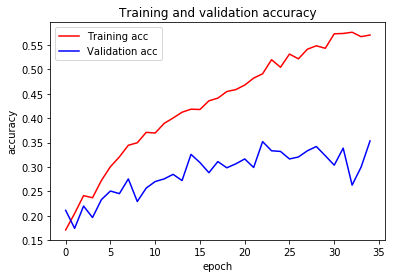

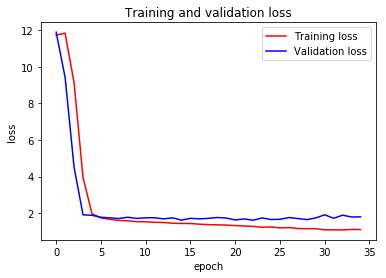

In [143]:
momentum = 0.8
learning_rate=0.01
sgd = SGD(lr=learning_rate, momentum=momentum, nesterov=False)
start = datetime.datetime.now()
model = Sequential()  
model.add(Flatten(input_shape=train_data.shape[1:]))  
model.add(Dense(1000, activation=keras.layers.LeakyReLU(alpha=0.3)))  
model.add(Dropout(0.5)) 
model.add(Dense(750, activation=keras.layers.LeakyReLU(alpha=0.3)))
model.add(Dropout(0.33))
model.add(Dense(500, activation=keras.layers.LeakyReLU(alpha=0.3)))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))  

model.compile(optimizer=sgd,  
          loss='categorical_crossentropy', metrics=['accuracy'])  

history = model.fit(train_data, train_labels,  
      epochs=35,  
      batch_size=500,  
      validation_data=(validation_data, validation_labels))  

model.save_weights(top_model_weights_path)  

(eval_loss, eval_accuracy) = model.evaluate(  
 validation_data, validation_labels, batch_size=batch_size, verbose=1)

print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100))  
print("[INFO] Loss: {}".format(eval_loss))  
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')  
plt.xlabel('epoch')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss')  
plt.xlabel('epoch')
plt.legend()
plt.show()

In [144]:
model.evaluate(test_data, test_labels)

120/120 [==============================] - 0s 2ms/step


[4.003949578603109, 0.233333333581686]

In [145]:
preds = np.round(model.predict(test_data),0)
classification_metrics = metrics.classification_report(test_labels, preds)
print(classification_metrics)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        20
           1       0.50      0.05      0.09        20
           2       0.67      0.10      0.17        20
           3       0.21      0.75      0.33        20
           4       0.40      0.20      0.27        20
           5       0.50      0.05      0.09        20

   micro avg       0.26      0.19      0.22       120
   macro avg       0.38      0.19      0.16       120
weighted avg       0.38      0.19      0.16       120
 samples avg       0.19      0.19      0.19       120



#### model 7. same as model 6 but with 20 epoch

Train on 9625 samples, validate on 1492 samples
Epoch 1/20
9625/9625 [==============================] - 17s 2ms/step - loss: 10.3847 - acc: 0.2002 - val_loss: 6.1847 - val_acc: 0.1769
Epoch 2/20
9625/9625 [==============================] - 16s 2ms/step - loss: 6.0045 - acc: 0.2268 - val_loss: 1.8159 - val_acc: 0.2446
Epoch 3/20
9625/9625 [==============================] - 17s 2ms/step - loss: 2.2699 - acc: 0.2466 - val_loss: 1.8255 - val_acc: 0.2091
Epoch 4/20
9625/9625 [==============================] - 17s 2ms/step - loss: 1.8184 - acc: 0.2750 - val_loss: 1.7839 - val_acc: 0.1991
Epoch 5/20
9625/9625 [==============================] - 16s 2ms/step - loss: 1.6969 - acc: 0.3029 - val_loss: 1.7689 - val_acc: 0.1971
Epoch 6/20
9625/9625 [==============================] - 18s 2ms/step - loss: 1.6546 - acc: 0.3161 - val_loss: 1.7566 - val_acc: 0.2614
Epoch 7/20
9625/9625 [==============================] - 17s 2ms/step - loss: 1.5993 - acc: 0.3350 - val_loss: 1.7680 - val_acc: 0.2225
Epoch 

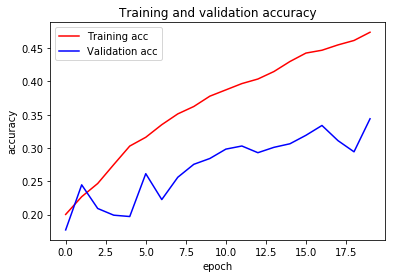

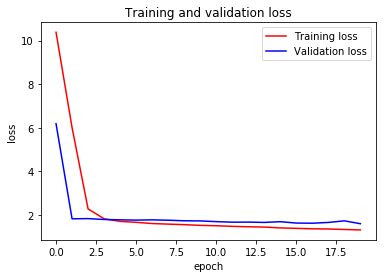

In [159]:
momentum = 0.8
learning_rate=0.01
sgd = SGD(lr=learning_rate, momentum=momentum, nesterov=False)
start = datetime.datetime.now()
model = Sequential()  
model.add(Flatten(input_shape=train_data.shape[1:]))  
model.add(Dense(1000, activation=keras.layers.LeakyReLU(alpha=0.3)))  
model.add(Dropout(0.5)) 
model.add(Dense(750, activation=keras.layers.LeakyReLU(alpha=0.3)))
model.add(Dropout(0.33))
model.add(Dense(500, activation=keras.layers.LeakyReLU(alpha=0.3)))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))  

model.compile(optimizer=sgd,  
          loss='categorical_crossentropy', metrics=['accuracy'])  

history = model.fit(train_data, train_labels,  
      epochs=20,  
      batch_size=500,  
      validation_data=(validation_data, validation_labels))  

model.save_weights(top_model_weights_path)  

(eval_loss, eval_accuracy) = model.evaluate(  
 validation_data, validation_labels, batch_size=batch_size, verbose=1)

print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100))  
print("[INFO] Loss: {}".format(eval_loss))  
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')  
plt.xlabel('epoch')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss')  
plt.xlabel('epoch')
plt.legend()
plt.show()

In [160]:
model.evaluate(test_data, test_labels)

120/120 [==============================] - 0s 1ms/step


[2.9632303873697916, 0.25000000024835267]

In [161]:
preds = np.round(model.predict(test_data),0)
classification_metrics = metrics.classification_report(test_labels, preds, label= organelles)
print(classification_metrics)

              precision    recall  f1-score   support

           0       1.00      0.05      0.10        20
           1       0.00      0.00      0.00        20
           2       0.00      0.00      0.00        20
           3       0.19      0.60      0.29        20
           4       0.57      0.20      0.30        20
           5       0.00      0.00      0.00        20

   micro avg       0.24      0.14      0.18       120
   macro avg       0.29      0.14      0.11       120
weighted avg       0.29      0.14      0.11       120
 samples avg       0.14      0.14      0.14       120



In [162]:
#Confusion matrix:
from sklearn.metrics import confusion_matrix
categorical_test_labels = pd.DataFrame(test_labels).idxmax(axis=1)
categorical_preds = pd.DataFrame(preds).idxmax(axis=1)

In [163]:
confusion_matrix= confusion_matrix(categorical_test_labels, categorical_preds)

In [164]:
#To get better visual of the confusion matrix:
def plot_confusion_matrix(cm, classes,
             normalize=False,
             title='Confusion matrix',
             cmap=plt.cm.Blues):
    #Add Normalization Option
    '''prints pretty confusion metric with normalization option '''
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
#     print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
organelles= ['cytoplasm', 'endosome', 'er', 'golgi', 'mitochondrion', 'nucleus']

Confusion matrix, without normalization


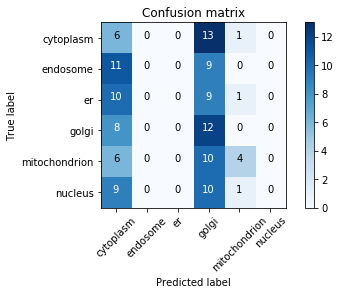

In [165]:
plot_confusion_matrix(confusion_matrix, organelles)

Normalized confusion matrix


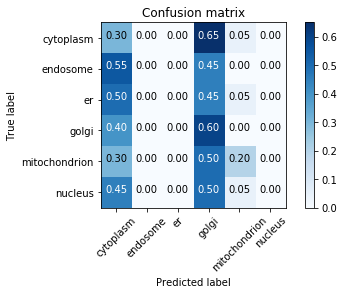

In [166]:
plot_confusion_matrix(confusion_matrix, ['cytoplasm', 'endosome', 'er', 'golgi', 'mitochondrion', 'nucleus'], normalize=True)

#### model 8. same as model 7 but with batch size at 300

Train on 9625 samples, validate on 1492 samples
Epoch 1/20
9625/9625 [==============================] - 16s 2ms/step - loss: 12.6731 - acc: 0.1701 - val_loss: 12.7152 - val_acc: 0.2111
Epoch 2/20
9625/9625 [==============================] - 15s 2ms/step - loss: 13.4337 - acc: 0.1665 - val_loss: 12.7152 - val_acc: 0.2111
Epoch 3/20
9625/9625 [==============================] - 15s 2ms/step - loss: 13.4337 - acc: 0.1665 - val_loss: 12.7152 - val_acc: 0.2111
Epoch 4/20
9625/9625 [==============================] - 15s 2ms/step - loss: 13.4337 - acc: 0.1665 - val_loss: 12.7152 - val_acc: 0.2111
Epoch 5/20
9625/9625 [==============================] - 15s 2ms/step - loss: 13.4337 - acc: 0.1665 - val_loss: 12.7152 - val_acc: 0.2111
Epoch 6/20
9625/9625 [==============================] - 15s 2ms/step - loss: 13.4337 - acc: 0.1665 - val_loss: 12.7152 - val_acc: 0.2111
Epoch 7/20
9625/9625 [==============================] - 15s 2ms/step - loss: 13.4337 - acc: 0.1665 - val_loss: 12.7152 - val_acc: 

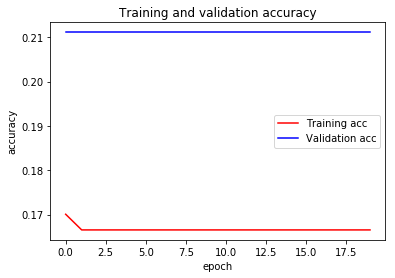

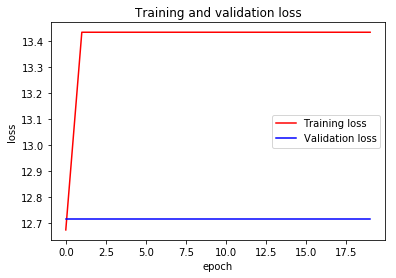

In [152]:
momentum = 0.8
learning_rate=0.01
sgd = SGD(lr=learning_rate, momentum=momentum, nesterov=False)
start = datetime.datetime.now()
model = Sequential()  
model.add(Flatten(input_shape=train_data.shape[1:]))  
model.add(Dense(1000, activation=keras.layers.LeakyReLU(alpha=0.3)))  
model.add(Dropout(0.5)) 
model.add(Dense(750, activation=keras.layers.LeakyReLU(alpha=0.3)))
model.add(Dropout(0.33))
model.add(Dense(500, activation=keras.layers.LeakyReLU(alpha=0.3)))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))  

model.compile(optimizer=sgd,  
          loss='categorical_crossentropy', metrics=['accuracy'])  

history = model.fit(train_data, train_labels,  
      epochs=20,  
      batch_size=300,  
      validation_data=(validation_data, validation_labels))  

model.save_weights(top_model_weights_path)  

(eval_loss, eval_accuracy) = model.evaluate(  
 validation_data, validation_labels, batch_size=batch_size, verbose=1)

print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100))  
print("[INFO] Loss: {}".format(eval_loss))  
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')  
plt.xlabel('epoch')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss')  
plt.xlabel('epoch')
plt.legend()
plt.show()

In [153]:
model.evaluate(test_data, test_labels)

120/120 [==============================] - 0s 1ms/step


[13.431746164957682, 0.16666666666666666]

In [154]:
preds = np.round(model.predict(test_data),0)
classification_metrics = metrics.classification_report(test_labels, preds)
print(classification_metrics)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        20
           1       0.17      1.00      0.29        20
           2       0.00      0.00      0.00        20
           3       0.00      0.00      0.00        20
           4       0.00      0.00      0.00        20
           5       0.00      0.00      0.00        20

   micro avg       0.17      0.17      0.17       120
   macro avg       0.03      0.17      0.05       120
weighted avg       0.03      0.17      0.05       120
 samples avg       0.17      0.17      0.17       120



#### model 9: same as model 6 but with epoch at 1000

In [10]:
train_labels

array([[1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.]], dtype=float32)

Train on 9625 samples, validate on 1492 samples
Epoch 1/20
9625/9625 [==============================] - 15s 2ms/step - loss: 9.7848 - acc: 0.1815 - val_loss: 10.8181 - val_acc: 0.2111
Epoch 2/20
9625/9625 [==============================] - 13s 1ms/step - loss: 11.8600 - acc: 0.1779 - val_loss: 8.7465 - val_acc: 0.2118
Epoch 3/20
9625/9625 [==============================] - 13s 1ms/step - loss: 8.4784 - acc: 0.2063 - val_loss: 4.4822 - val_acc: 0.1930
Epoch 4/20
9625/9625 [==============================] - 13s 1ms/step - loss: 4.0011 - acc: 0.2284 - val_loss: 2.0749 - val_acc: 0.2024
Epoch 5/20
9625/9625 [==============================] - 13s 1ms/step - loss: 2.1228 - acc: 0.2517 - val_loss: 1.8129 - val_acc: 0.2031
Epoch 6/20
9625/9625 [==============================] - 14s 1ms/step - loss: 1.8719 - acc: 0.2806 - val_loss: 1.7871 - val_acc: 0.2239
Epoch 7/20
9625/9625 [==============================] - 13s 1ms/step - loss: 1.7575 - acc: 0.2982 - val_loss: 1.7647 - val_acc: 0.2346
Epoch

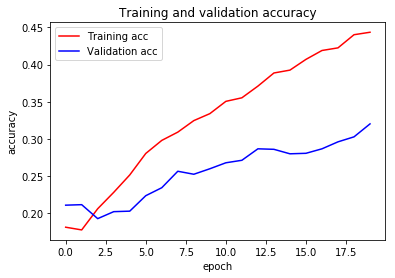

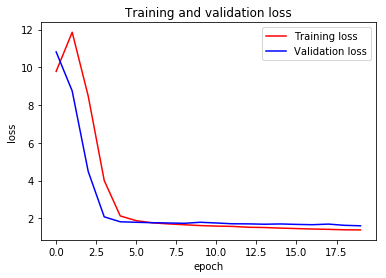

In [156]:
momentum = 0.8
learning_rate=0.01
sgd = SGD(lr=learning_rate, momentum=momentum, nesterov=False)
start = datetime.datetime.now()
model = Sequential()  
model.add(Flatten(input_shape=train_data.shape[1:]))  
model.add(Dense(1000, activation=keras.layers.LeakyReLU(alpha=0.3)))  
model.add(Dropout(0.5)) 
model.add(Dense(750, activation=keras.layers.LeakyReLU(alpha=0.3)))
model.add(Dropout(0.33))
model.add(Dense(500, activation=keras.layers.LeakyReLU(alpha=0.3)))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))  

model.compile(optimizer=sgd,  
          loss='categorical_crossentropy', metrics=['accuracy'])  

history = model.fit(train_data, train_labels,  
      epochs=20,  
      batch_size=1000,  
      validation_data=(validation_data, validation_labels))  

model.save_weights(top_model_weights_path)  

(eval_loss, eval_accuracy) = model.evaluate(  
 validation_data, validation_labels, batch_size=batch_size, verbose=1)

print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100))  
print("[INFO] Loss: {}".format(eval_loss))  
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')  
plt.xlabel('epoch')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss')  
plt.xlabel('epoch')
plt.legend()
plt.show()

In [157]:
model.evaluate(test_data, test_labels)

120/120 [==============================] - 0s 2ms/step


[2.534841267267863, 0.24166666666666667]

In [158]:
preds = np.round(model.predict(test_data),0)
classification_metrics = metrics.classification_report(test_labels, preds)
print(classification_metrics)

              precision    recall  f1-score   support

           0       1.00      0.05      0.10        20
           1       0.00      0.00      0.00        20
           2       0.00      0.00      0.00        20
           3       0.21      0.60      0.31        20
           4       1.00      0.05      0.10        20
           5       0.00      0.00      0.00        20

   micro avg       0.23      0.12      0.16       120
   macro avg       0.37      0.12      0.08       120
weighted avg       0.37      0.12      0.08       120
 samples avg       0.12      0.12      0.12       120

